In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime
from joblib import Parallel, delayed

Capture hides output

In [2]:
%%capture
%run cowling_approximation6_method2.ipynb

In [3]:
def process(k):
    df = pd.read_csv(path)
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)
    
    # Initial Conditions
    km2cm = 1e5
    r_i = 1
    p0 = p_arr[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    omega = 2e3*(2*np.pi) #Arbitrary guess
    l=2
    v0 = -1 # Two step integration optimization: similar to phi previously.
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    p_min = 1*(c**2)

    init_VEC = [p_c, m0, v0, W0, U0]
    init_params = [EOS, l, omega]
    init_t = [r_i, 21 * km2cm]
    eval_t = np.linspace(r_i, 20 * km2cm, 1000)

    # Integrate
    sol = solve_ivp(fun = coupledTOV, 
                   t_span = init_t,
                   y0 = init_VEC,
                   args = [init_params],
                   method = "Radau",
                   t_eval = eval_t)

    p_total = sol.y[0]
    try: 
        surface_idx = np.where(np.diff(p_total) == 0)[0][0]
    except:
        surface_idx = len(sol.y[0])
    p, m, v, w, u = sol.y[:, :surface_idx]
    r_arr = sol.t[:surface_idx]

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    # Reassign initial conditions. 
    v_ext = -_lamda(r_R, m_R)
    v_int = v_R #At surface
    delta_v = v_int - v_ext
    v0 =  v0 - delta_v
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]

    time.sleep(0.2)

    sol = solve_ivp(fun = coupledTOV, 
                   t_span = init_t,
                   y0 = init_VEC,
                   args = [init_params],
                   method = "Radau",
                   t_eval = eval_t)

    p_total = sol.y[0]

    try: 
        surface_idx = np.where(np.diff(p_total) == 0)[0][0]
    except:
        surface_idx = len(sol.y[0])

    p, m, v, w, u = sol.y[:, :surface_idx]
    r_arr = sol.t[:surface_idx]

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    
    def minimize_boundary_mass_plot(params, p = p, EOS = EOS):
        # Repeat integration

        omega = params

        # Integrate
        sol = solve_ivp(fun = coupledTOV, 
                       t_span = init_t,
                       y0 = init_VEC,
                       args = [init_params],
                       method = "Radau",
                       t_eval = eval_t)

        p_total = sol.y[0]

        try: 
            surface_idx = np.where(np.diff(p_total) == 0)[0][0]
        except:
            surface_idx = len(sol.y[0])

        p, m, v, w, u = sol.y[:, :surface_idx]
        r_arr = sol.t[:surface_idx]

        max_idx = np.argmax(m)
        m_R = m.max() # In units of msun
        r_R = r_arr[max_idx] # In units of km
        p_R = p[max_idx] #cgs
        ec_R = EOS(p_R) #cgs
        u_R = u[max_idx] #cgs
        v_R = v[max_idx]
        w_R = w[max_idx]

        loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
        return loss

    omega_guess = 0.1e3*(2*np.pi)
    init_guess = [omega_guess]
    res = minimize(minimize_boundary_mass_plot, x0 = init_guess, 
                   method='Nelder-Mead', 
                   options = {"disp": False, "maxiter":15},
                   tol = 1)

    omg = res.x[0]
    f = omg/(2*np.pi)
    return f, m_R, r_R, k

In [4]:
f_mode_list = []
mass_list = []
radius_list = []

if path == "eos_data/nl3cr_short.csv":
    print("EOS: NL3CR (Short)")
    ind_start = -4
    ind_stop = -1180
    jump = 20 # Default should be 1 for small EOS data
    
if path == "eos_data/nl3cr.csv" :
    print("EOS: NL3CR (Full)")
    ind_start = -2
    ind_stop = -1140
    jump = 20 # Default should be 1 for small EOS data
    
if (path == "eos_data/sly230a_short.csv") \
    or (path =="eos_data/sly230a.csv"):
    print("EOS: SLY230A (Full)")
    ind_start = -10
    ind_stop = -120
    jump = 5 # Default should be 1 for small EOS data
    
if path == "eos_data/sly_short.csv":
    print("EOS: SLY4 (Short)")
    ind_start = -2
    ind_stop = -28
    jump = 1 # Default should be 1 for small EOS data
    
if path == "eos_data/sly.csv": 
    print("EOS: SLY4 (Full)")
    ind_start = -2
    ind_stop = -26
    jump = 1 # Default should be 1 for small EOS data

path2 = None
# path2 = "polytrope"
    
if path2 == "polytrope":
    ind_start = -2
    ind_stop = -200
    jump = 5
    
vals = range(ind_stop, ind_start+1, 1)[::-jump]

results = Parallel(n_jobs=-2, 
                   verbose=0,
                   max_nbytes='8M')(delayed(process)(k) for k in tqdm(vals))

EOS: NL3CR (Full)


In [5]:
mass_arr = np.array(results).T[1]
f_mode_arr = np.array(np.array(results).T[0])
radius_arr = np.array(results).T[2]
idx_arr = np.array(results).T[3]
hz2khz = 1e-3

In [6]:
mass_arr

array([4.99174254e+33, 5.00967061e+33, 5.02785910e+33, 5.04624250e+33,
       5.06483910e+33, 5.08363689e+33, 5.10265480e+33, 5.12183824e+33,
       5.14119256e+33, 5.16069178e+33, 5.18032860e+33, 5.20007841e+33,
       5.21991446e+33, 5.23979303e+33, 5.25970158e+33, 5.27957861e+33,
       5.29938015e+33, 5.31906033e+33, 5.33854223e+33, 5.35776637e+33,
       5.37664046e+33, 5.39507095e+33, 5.41295097e+33, 5.43013332e+33,
       5.44647744e+33, 5.46179990e+33, 5.47590636e+33, 5.48855178e+33,
       5.49946441e+33, 5.50832647e+33, 5.51474342e+33, 5.51827343e+33,
       5.51839702e+33, 5.51449336e+33, 5.50582448e+33, 5.49154338e+33,
       5.47059739e+33, 5.44176511e+33, 5.40359128e+33, 5.35436729e+33,
       5.29205105e+33, 5.21413621e+33, 5.11779778e+33, 4.99983703e+33,
       4.85648854e+33, 4.68380346e+33, 4.47784280e+33, 4.23529907e+33,
       3.95460983e+33, 3.63712957e+33, 3.28917411e+33, 2.92275637e+33,
       2.55423883e+33, 2.20046790e+33, 1.87372444e+33, 1.57867240e+33,
      

In [7]:
max_idx = mass_arr.argmax()
# idx_arr[(np.abs(mass_arr/msun - 1.4)).argmin()]

In [8]:
mass_arr = mass_arr[max_idx:]
f_mode_arr = f_mode_arr[max_idx:]
radius_arr = radius_arr[max_idx:]

In [9]:
max_idx_new = mass_arr.argmax()

print(f"M_max = {mass_arr[max_idx_new]/msun}")
print(f"R_max = {radius_arr[max_idx_new]/km2cm}")
print(f"f_max = {f_mode_arr[max_idx_new]}")

print()
solar_idx = (np.abs(mass_arr/msun - 1.4)).argmin()
print(f"M_1.4 = {mass_arr[solar_idx]/msun}")
print(f"R_1.4 = {radius_arr[solar_idx]/km2cm}")
print(f"f_1.4 = {f_mode_arr[solar_idx]}")

M_max = 2.775197522063397
R_max = 13.393396696696696
f_max = 1735.0

M_1.4 = 1.469851878586927
R_1.4 = 14.914917457457458
f_1.4 = 1450.0000000000002


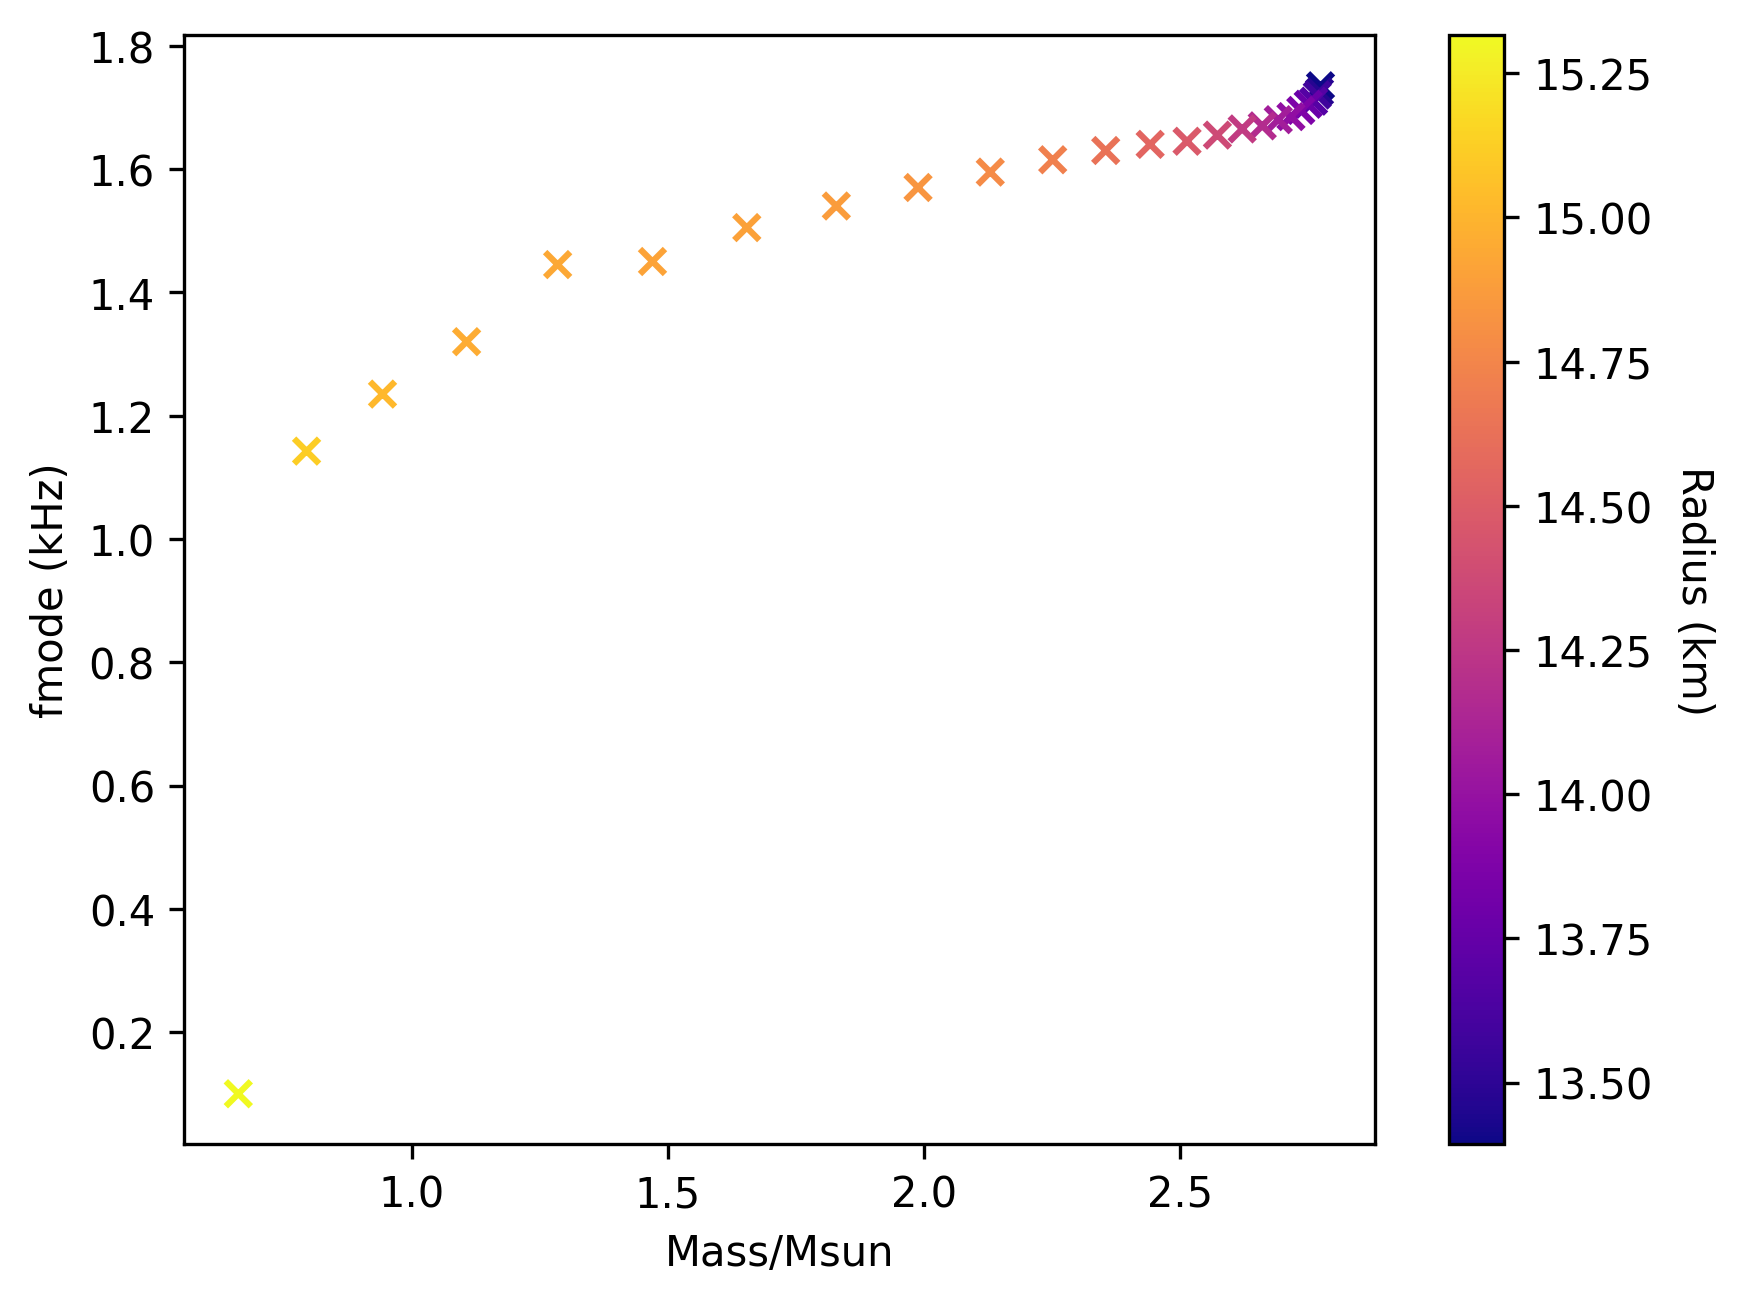

In [15]:
# mass_arr = np.array(mass_list)
# f_mode_arr = np.array(f_mode_list)
# radius_arr = np.array(radius_list)
# hz2khz = 1e-3

plt.figure(dpi = 300)
plt.tight_layout()
plt.scatter(mass_arr/msun, f_mode_arr*hz2khz, c = radius_arr/km2cm, marker = "x", 
            cmap = "plasma")
plt.xlabel("Mass/Msun")
plt.ylabel("fmode (kHz)")
cbar = plt.colorbar()
cbar.set_label('Radius (km)', rotation=-90, labelpad=15)
# utkarshGrid()
plt.xlim(1, 2.5)
plt.ylim(1.5, 3.5)
plt.show()

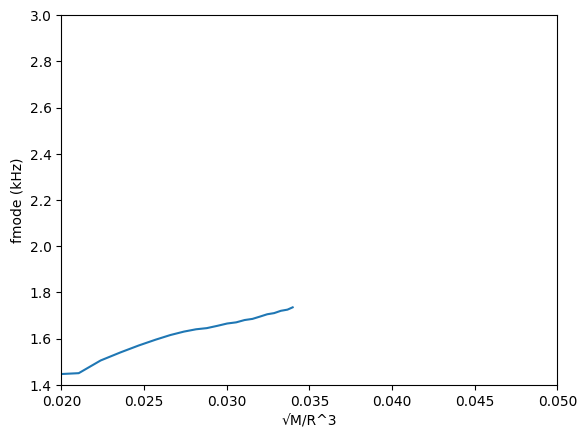

In [11]:
plt.plot(np.sqrt((mass_arr/msun)/((radius_arr/km2cm)**3)), f_mode_arr*hz2khz)
plt.xlabel("√M/R^3")
plt.ylabel("fmode (kHz)")
plt.xlim(0.02, 0.05)
plt.ylim(1.4, 3)
plt.show()

In [12]:
# plt.plot(np.sqrt((mass_arr/(1.4*msun))/((radius_arr/(10*km2cm))**3)), f_mode_arr*hz2khz)
# plt.ylabel("f(khz)")
# plt.show()

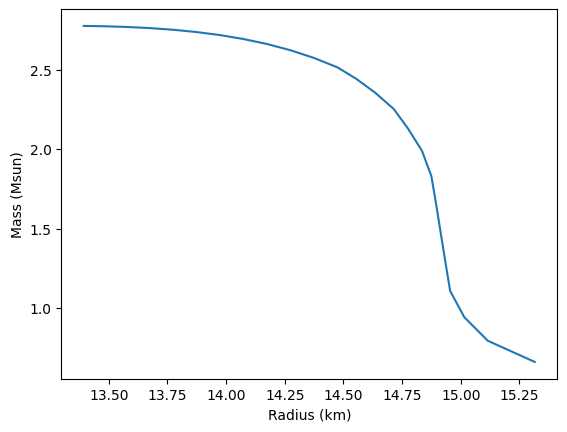

In [13]:
plt.plot(radius_arr/km2cm, mass_arr/msun)
plt.xlabel("Radius (km)")
plt.ylabel("Mass (Msun)")
plt.show()

In [14]:
# np.savetxt("mr_sly.csv", np.array([radius_arr, mass_arr]).T)